### Loading data

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


(50000, 28, 28) (50000,)


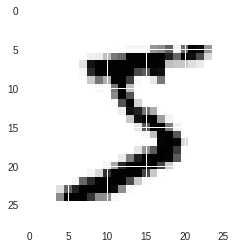

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

### Defining Hyperparameters

In [0]:
n_classes = 10
learning_rate = 0.0001
keep_prob = 0.5
starter_learning_rate = 0.00036
num_epochs = 1000
mini_batch_size = 64

n_train = X_train.shape[0]
n_valid = X_val.shape[0]
n_test = X_test.shape[0]

### Data preprocessing

In [4]:
X_train = X_train.reshape(n_train, -1).T
X_val = X_val.reshape(n_valid, -1).T
X_test = X_test.reshape(n_test, -1).T
X_train.shape

(784, 50000)

In [5]:
n_features = X_train.shape[0]
n_features

784

In [0]:
def convert_to_one_hot(y, n_classes):
    y = np.eye(n_classes)[y]
    return y

In [7]:
one_hot_y_train = convert_to_one_hot(y_train, n_classes).T
one_hot_y_val = convert_to_one_hot(y_val, n_classes).T
one_hot_y_test = convert_to_one_hot(y_test, n_classes).T
one_hot_y_train.shape, one_hot_y_val.shape, one_hot_y_test.shape

((10, 50000), (10, 10000), (10, 10000))

### Data Generator

In [0]:
def generate_mini_batches(X, y, mini_batch_size, n_train):
  mini_batches = []
  index = np.random.permutation(n_train)
  shuffled_X = X[:, index]
  shuffled_y = y[:, index]
  batches = n_train//mini_batch_size
  for i in range(batches):
    mini_batch_X = shuffled_X[:, i*mini_batch_size:(i+1)*mini_batch_size]
    mini_batch_y = shuffled_y[:, i*mini_batch_size:(i+1)*mini_batch_size]  
    mini_batches.append((mini_batch_X, mini_batch_y))
  mini_batches.append((shuffled_X[:, batches*mini_batch_size:], shuffled_y[:, batches*mini_batch_size:]))
  return mini_batches

In [9]:
mini_batches = generate_mini_batches(X_train, one_hot_y_train, mini_batch_size, n_train)
len(mini_batches), len(mini_batches[0]), len(mini_batches[0][0]), len(mini_batches[0][1]), len(mini_batches[0][0][0]), len(mini_batches[0][1][0])

(782, 2, 784, 10, 64, 64)

### Defining Inputs and Outputs 

In [0]:
def initialize_placeholders():
  X = tf.placeholder(shape=[n_features, None], dtype=tf.float32, name='X')
  y = tf.placeholder(shape=[n_classes, None], dtype=tf.float32, name='y')
  return X, y

### Defining Model Parameters and Other Variables

In [0]:
def initialize_parameters():
  W1 = tf.get_variable("W1", [128, 784], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
  b1 = tf.get_variable("b1", [128,1], initializer = tf.zeros_initializer())
  W2 = tf.get_variable("W2", [128, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
  b2 = tf.get_variable("b2", [128,1], initializer = tf.zeros_initializer())
  W3 = tf.get_variable("W3", [10, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
  b3 = tf.get_variable("b3", [10,1], initializer = tf.zeros_initializer())
  
  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3
               }
  
  return parameters

### Defining Inference of the Model



In [0]:
def forward_propagation(X, y, parameters):
  W1, b1, W2, b2, W3, b3 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2'], parameters['W3'], parameters['b3']
  Z1 = tf.add(tf.matmul(W1, X), b1)
  A1 = tf.nn.relu(Z1)
  Z2 = tf.add(tf.matmul(W2, A1), b2)
  A2 = tf.nn.relu(Z2)
  #A2 = tf.nn.dropout(A2, keep_prob)
  Z3 = tf.add(tf.matmul(W3, A2), b3)
  return Z3

### Defining Loss

In [0]:
def compute_loss(Z, y):
  logits = tf.transpose(Z)
  labels = tf.transpose(y)
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

### Training

In [0]:
def model():
  ops.reset_default_graph()
  costs = []
  X, y = initialize_placeholders()
  parameters = initialize_parameters()
  Z3 = forward_propagation(X, y, parameters)
  cost = compute_loss(Z3, y)
  #global_step = tf.Variable(0, trainable=False)
  #learning_rate = tf.train.exponential_decay(learning_rate, global_step, 100, 0.85, staircase=True)
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
  
  init = tf.global_variables_initializer()
  
  sess = tf.InteractiveSession()
  sess.run(init)
  
  for epoch in range(num_epochs):
    epoch_cost = 0
    num_minibatches = int(n_train / mini_batch_size) 
    mini_batches = generate_mini_batches(X_train, one_hot_y_train, mini_batch_size, n_train)
    
    for mini_batch in mini_batches:
      (mini_batch_X, mini_batch_y) = mini_batch
      _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X:mini_batch_X,
                                           y:mini_batch_y})
      epoch_cost+= minibatch_cost/num_minibatches 
    
    if epoch % 50 == 0:
      print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
    if epoch %5 ==0:
      costs.append(epoch_cost)
    
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('iterations (per tens)')
  plt.title("Cost Convergence")
  plt.show()
  
  parameters = sess.run(parameters)
  
  accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(A3), tf.arg_max(y)), dtype=tf.float32))
  
  
  print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
  print ("Validation Accuracy:", accuracy.eval({X: X_val, Y: Y_val}))
  
  return parameters

In [0]:
parameters = model()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 0.766582
Cost after epoch 50: 0.005448
Cost after epoch 100: 0.000136
Cost after epoch 150: 0.000016
Cost after epoch 200: 0.000003
Cost after epoch 250: 0.000001
Cost after epoch 300: 0.000002
Cost after epoch 350: 0.000000
Cost after epoch 400: 0.000000
Cost after epoch 450: 0.000000
